# Shockwave

In [49]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [50]:
# Parameters
L = 1.0         # Length of the domain
T = 1.0         # Total simulation time
Nx = 200        # Number of spatial points
Nt = 800        # Number of time steps
dx = L / (Nx - 1)
dt = T / Nt

In [51]:
# Initial conditions
x = np.linspace(0, L, Nx)
gamma = 1.4
u = 0.75*np.ones(Nx) #np.exp(-(x - 0.5*L)**2 / 0.1)             # Velocity
u[60:] = 0
rho = np.ones(Nx)
rho[60:] = 0.125
press = np.ones(Nx)
press[60:] = 0.1

energy = np.zeros(Nx)
energy = press/((gamma - 1)) + 0.5*rho*u**2

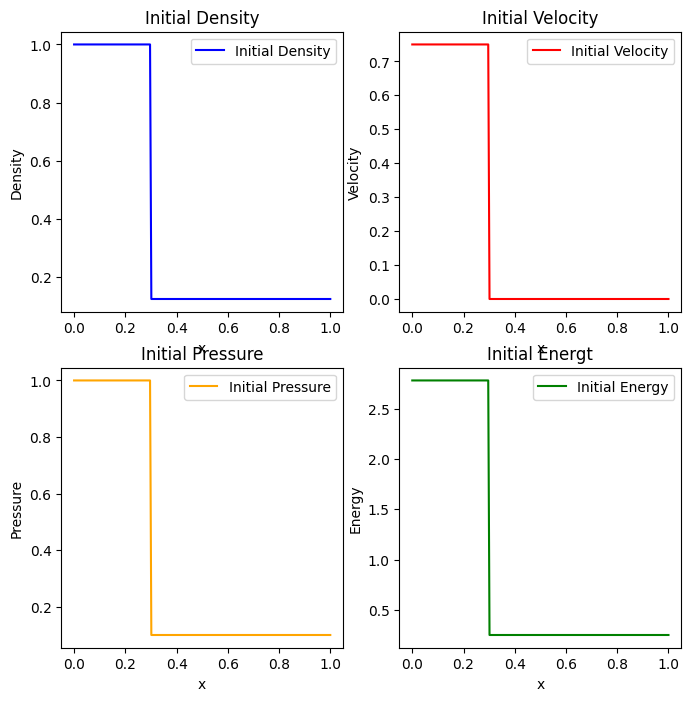

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(x, rho, label='Initial Density', color='blue')
axs[0,0].set_title('Initial Density')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[0,1].plot(x, u, label='Initial Velocity', color='red')
axs[0,1].set_title('Initial Velocity')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,0].plot(x, press, label='Initial Pressure', color='orange')
axs[1,0].set_title('Initial Pressure')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[1,1].plot(x, energy, label='Initial Energy', color='green')
axs[1,1].set_title('Initial Energt')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Energy')
axs[1,1].legend()

### Lax-Wendroff

In [109]:
sol_rho = np.zeros((rho.shape[0], Nt+1))
sol_mom = np.zeros((rho.shape[0], Nt+1))
sol_ene = np.zeros((rho.shape[0], Nt+1))
sol_pre = np.zeros((rho.shape[0], Nt+1))


sol_rho[:, 0] = rho
sol_mom[:, 0] = rho * u
sol_ene[:, 0] = energy

In [93]:
diff_rho = np.zeros(Nx)
diff_mom = np.zeros(Nx)
diff_ene = np.zeros(Nx)
v = np.zeros(Nx)
v_prov = np.zeros(Nx-1)
v[sol_rho[:,0]!=0] = sol_mom[:, 0][sol_rho[:,0]!=0]/sol_rho[:,0][sol_rho[:,0]!=0]

for i in range(1, Nt+1):
    press = sol_pre[:,i-1]
    f_rho = sol_mom[:,i-1]
    f_mom = press + sol_rho[:,i-1]*v**2
    f_ene = v * (sol_ene[:,i-1] + press)
    
    u_prov = 0.5*(sol_mom[1:,i-1] + sol_mom[:-1,i-1]) - 0.5*dt*(f_mom[1:] - f_mom[:-1])/dx
    r_prov = 0.5*(sol_rho[1:,i-1] + sol_rho[:-1,i-1]) - 0.5*dt*(f_rho[1:] - f_rho[:-1])/dx
    e_prov = 0.5*(sol_ene[1:,i-1] + sol_ene[:-1,i-1]) - 0.5*dt*(f_ene[1:] - f_ene[:-1])/dx

    v_prov[r_prov!=0] = u_prov[r_prov!=0]/r_prov[r_prov!=0]
    press_prov = (gamma - 1) * (e_prov - 0.5*r_prov * v_prov**2) 
    f_rho_prov = u_prov
    f_mom_prov = press_prov + r_prov*v_prov**2
    f_ene_prov = v_prov*(e_prov + press_prov)

    diff_rho[1:-1] = f_rho_prov[1:] - f_rho_prov[:-1]
    diff_mom[1:-1] = f_mom_prov[1:] - f_mom_prov[:-1]
    diff_ene[1:-1] = f_ene_prov[1:] - f_ene_prov[:-1]

    sol_mom[:,i] = sol_mom[:,i-1] - dt*(diff_mom)/dx
    sol_rho[:,i] = sol_rho[:,i-1] - dt*(diff_rho)/dx
    sol_ene[:,i] = sol_ene[:,i-1] - dt*(diff_ene)/dx
    
    v[sol_rho[:,i]!=0] = sol_mom[:, i][sol_rho[:,i]!=0]/sol_rho[:,i][sol_rho[:,i]!=0]
    sol_pre[:,i] = (gamma - 1) *(sol_ene[:,i] - 0.5* sol_rho[:,i]* v**2)

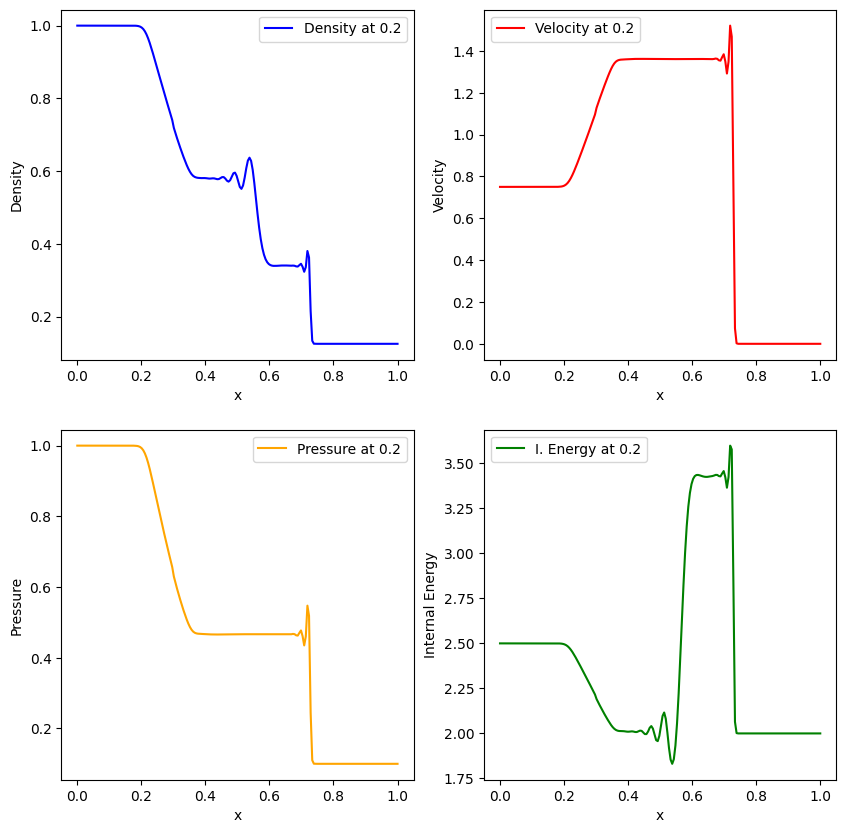

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
idx = 160
axs[0,0].plot(x, sol_rho[:,idx], label=f'Density at {T * idx/Nt}', color='blue')
axs[0,0].set_title('')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[1,0].plot(x, sol_pre[:,idx], label=f'Pressure at {T * idx/Nt}', color='orange')
axs[1,0].set_title('')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[0,1].plot(x, sol_mom[:,idx]/sol_rho[:,idx], label=f'Velocity at {T * idx/Nt}', color='red')
axs[0,1].set_title('')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,1].plot(x, (sol_ene[:,idx]/sol_rho[:,idx] - 0.5*(sol_mom[:,idx]/sol_rho[:,idx])**2), label=f'I. Energy at {T * idx/Nt}', color='green')
axs[1,1].set_title('')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Internal Energy')
axs[1,1].legend()
plt.show()

### ROE 

In [169]:
def trrs(ul, ur, al, ar, pl, pr, Q=2, gamma=1.4):
    z = (gamma-1)/(2*gamma)
    num = al + ar - 0.5*(gamma-1)*(ur-ul)
    den = al/pl**z + ar/pr**z
    p_ = (num/den)**(1/z)
    al_, ar_ = al*(p_/pl)**z, ar*(p_/pr)**z
    ul_, ur_ = ul + 2*(al - al_)/(gamma-1), ur + 2*(ar_ - ar)/(gamma-1) 

    return al_, ar_, ul_, ur_

def roe_flux(rho_l, rho_r, u_l, u_r, e_l, e_r, p_l, p_r, gamma):
    # Obtain entalpy
    h_l = (e_l + p_l)/rho_l
    h_r = (e_r + p_r)/rho_r

    # Obtain Roe averages
    rho_det = np.sqrt(rho_l) + np.sqrt(rho_r)
    rho_avg = np.sqrt(rho_l*rho_r)
    u_avg = (np.sqrt(rho_l)*u_l + np.sqrt(rho_r)*u_r)/rho_det
    h_avg = (np.sqrt(rho_l)*h_l + np.sqrt(rho_r)*h_r)/rho_det
    a_avg =  np.sqrt((gamma-1)*(h_avg - 0.5*u_avg**2))

    # Obtain eigenvalues
    l_1 = u_avg - a_avg
    l_2 = u_avg
    l_3 = u_avg + a_avg

    # Compute coefs
    alp_1 = 0.5*(1/a_avg**2) * (p_r - p_l - rho_avg*a_avg*(u_r - u_l))
    alp_2 = rho_r - rho_l - (p_r - p_l)/a_avg**2
    alp_3 = 0.5*(1/a_avg**2) * (p_r - p_l + rho_avg*a_avg*(u_r - u_l))

    # Compute eigenvectors
    K1 = np.array([np.ones(u_avg.shape[0]), u_avg - a_avg, h_avg - u_avg*a_avg])
    K2 = np.array([np.ones(u_avg.shape[0]), u_avg, 0.5*u_avg**2])
    K3 = np.array([np.ones(u_avg.shape[0]), u_avg + a_avg, h_avg + u_avg*a_avg])

    # Entropy fix
    al, ar = np.sqrt(gamma*p_l/rho_l), np.sqrt(gamma*p_r/rho_r)
    al_, ar_, ul_, ur_ = trrs(u_l, u_r, al, ar, p_l, p_r, gamma=gamma)
    l_1l = u_l - al
    l_1r = ul_ - al_
    l_3l = ur_ - ar_
    l_3r = u_r - ar
    
    idx1 = np.logical_and(l_1l < 0, l_1r > 0)
    idx3 = np.logical_and(l_3l < 0, l_3r > 0)

    l1_bar = l_1l*(l_1r - l_1)/(l_1r - l_1l)
    l3_bar = l_3r*(l_3 - l_3l)/(l_3r - l_3l)

    # Roe flux
    #idx_body = np.logical_or(np.logical_not(idx1), np.logical_not(idx3))
    flux_rho = 0.5 * (rho_l*u_l + rho_r*u_r)
    flux_rho -= 0.5*(np.abs(l_1)*alp_1*K1[0] + np.abs(l_2)*alp_2*K2[0] + np.abs(l_3)*alp_3*K3[0])
    flux_mom = 0.5 * (rho_l*u_l**2 + p_l + rho_r*u_r**2 + p_r) 
    flux_mom -= 0.5*(np.abs(l_1)*alp_1*K1[1] + np.abs(l_2)*alp_2*K2[1] + np.abs(l_3)*alp_3*K3[1])
    flux_ene = 0.5 * (u_l*(e_l + p_l) + u_r*(e_r + p_r)) 
    flux_ene -= 0.5*(np.abs(l_1)*alp_1*K1[2] + np.abs(l_2)*alp_2*K2[2] + np.abs(l_3)*alp_3*K3[2])

    flux_rho[idx1] = rho_l[idx1] * u_l[idx1] + l1_bar[idx1] * alp_1[idx1]*K1[0][idx1]
    flux_mom[idx1] = rho_l[idx1] * u_l[idx1]**2 + p_l[idx1] + l1_bar[idx1] * alp_1[idx1]*K1[1][idx1]
    flux_ene[idx1] = u_l[idx1]*(e_l[idx1] + p_l[idx1]) + l1_bar[idx1] * alp_1[idx1]*K1[2][idx1]

    flux_rho[idx3] = rho_r[idx3] * u_r[idx3] + l3_bar[idx3] * alp_3[idx3]*K3[0][idx3]
    flux_mom[idx3] = rho_r[idx3] * u_r[idx3]**2 + p_r[idx3] + l3_bar[idx3] * alp_3[idx3]*K3[1][idx3]
    flux_ene[idx3] = u_r[idx3]*(e_r[idx3] + p_r[idx3]) + l3_bar[idx3] * alp_3[idx3]*K3[2][idx3]

    return flux_rho, flux_mom, flux_ene



In [173]:
sol_rho = np.zeros((rho.shape[0], Nt+1))
sol_mom = np.zeros((rho.shape[0], Nt+1))
sol_ene = np.zeros((rho.shape[0], Nt+1))
sol_pre = np.zeros((rho.shape[0], Nt+1))

v = np.zeros(Nx)
diff_rho = np.zeros(Nx)
diff_mom = np.zeros(Nx)
diff_ene = np.zeros(Nx)

sol_rho[:, 0] = rho
sol_mom[:, 0] = rho * u
sol_ene[:, 0] = energy
sol_pre[:, 0] = press
v[sol_rho[:,0]!=0] = sol_mom[:, 0][sol_rho[:,0]!=0]/sol_rho[:,0][sol_rho[:,0]!=0]

for i in range(1, Nt + 1):
    flux_rho, flux_mom, flux_ene = roe_flux(sol_rho[:-1, i-1], sol_rho[1:, i-1],
                                            v[:-1], v[1:],
                                            sol_ene[:-1, i-1], sol_ene[1:, i-1],
                                            sol_pre[:-1, i-1], sol_pre[1:, i-1],
                                            gamma)
    
    diff_rho[1:-1] =  (flux_rho[:-1] - flux_rho[1:])
    diff_mom[1:-1] =  (flux_mom[:-1] - flux_mom[1:])
    diff_ene[1:-1] =  (flux_ene[:-1] - flux_ene[1:])
    sol_rho[:,i] = sol_rho[:,i-1] + (dt/dx)*diff_rho
    sol_mom[:,i] = sol_mom[:,i-1] + (dt/dx)*diff_mom
    sol_ene[:,i] = sol_ene[:,i-1] + (dt/dx)*diff_ene
    v[sol_rho[:,i]!=0] = sol_mom[:, i][sol_rho[:,i]!=0]/sol_rho[:,i][sol_rho[:,i]!=0]
    sol_pre[:,i] = (gamma - 1) *(sol_ene[:,i] - 0.5* sol_rho[:,i]* v**2)

C:\Users\daaba\AppData\Local\Temp\ipykernel_11456\1224786071.py:39: RuntimeWarning: invalid value encountered in sqrt
  al, ar = np.sqrt(gamma*p_l/rho_l), np.sqrt(gamma*p_r/rho_r)
C:\Users\daaba\AppData\Local\Temp\ipykernel_11456\1224786071.py:4: RuntimeWarning: invalid value encountered in power
  den = al/pl**z + ar/pr**z
C:\Users\daaba\AppData\Local\Temp\ipykernel_11456\1224786071.py:50: RuntimeWarning: divide by zero encountered in divide
  l3_bar = l_3r*(l_3 - l_3l)/(l_3r - l_3l)


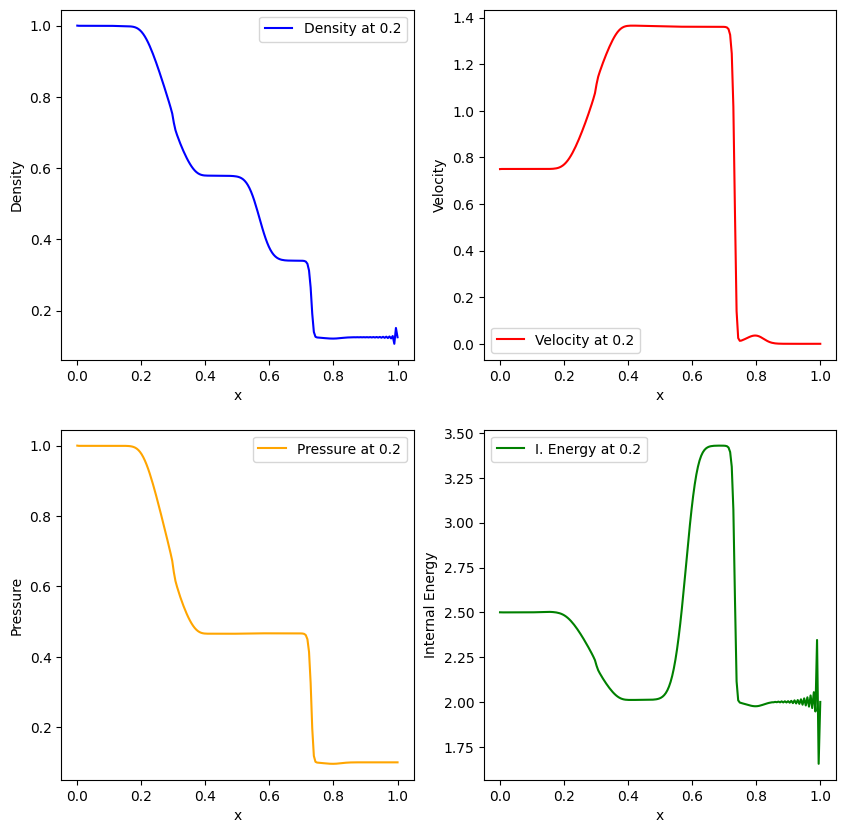

In [174]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
idx = 160
axs[0,0].plot(x, sol_rho[:,idx], label=f'Density at {T * idx/Nt}', color='blue')
axs[0,0].set_title('')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[1,0].plot(x, sol_pre[:,idx], label=f'Pressure at {T * idx/Nt}', color='orange')
axs[1,0].set_title('')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[0,1].plot(x, sol_mom[:,idx]/sol_rho[:,idx], label=f'Velocity at {T * idx/Nt}', color='red')
axs[0,1].set_title('')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,1].plot(x, (sol_ene[:,idx]/sol_rho[:,idx] - 0.5*(sol_mom[:,idx]/sol_rho[:,idx])**2), label=f'I. Energy at {T * idx/Nt}', color='green')
axs[1,1].set_title('')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Internal Energy')
axs[1,1].legend()
plt.show()